# Imports

In [9]:
import cv2
import numpy as np
import pandas as pd
import sys
import glob 
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from matplotlib import pyplot as plt

# Useful Methods

In [5]:
def resize(frame, scale):
    return cv2.resize(frame, (int(frame.shape[1] * scale), int(frame.shape[0] * scale) ))

def get_features_with_label(img_data, hog, label):
    dims = (80, 80)
    data = []
    for img in img_data:
        img = cv2.resize(img, dims)
        feat = hog.compute( img[:, :, :] )
        data.append( (feat, label) )
    return data

def init_hog():
    min_dims = 80
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    bins = 9
    dims = (80, 80)
    hog = cv2.HOGDescriptor(dims, block_size, block_stride, cell_size, bins)
    return hog


def train_svm(svm, hog, positive_images_path, negative_images_path):
    pos_imgs = []
    neg_imgs = []
    for img in glob.glob(positive_images_path):
        pos_imgs.append( cv2.imread(img) )
    for img in glob.glob(negative_images_path):
        neg_imgs.append( cv2.imread(img) )

    positive_data = get_features_with_label(pos_imgs, hog, 1)
    negative_data = get_features_with_label(neg_imgs, hog, 0)
    data_df = positive_data + negative_data
    np.random.shuffle(data_df)

    feat, labels = map(list, zip(*data_df) )
    feat_flat = [x.flatten() for x in feat]
    X_df = pd.DataFrame(feat_flat)
    y_df = pd.Series(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        X_df,
        y_df,
        test_size=0.3,
        random_state=2
    )
    svm.fit(X_train, y_train)

def scaled(frame, scale): # returns new scale value
    frame_shape_x, frame_shape_y, channels = frame.shape
    if(frame_shape_x > scale):
        return scale / frame_shape_x
    else:
        return 1

def color_filter(frame, lower_upper_list):
    lower = np.array(lower_upper_list[0], dtype="uint8")
    upper = np.array(lower_upper_list[1], dtype="uint8")

    mask = cv2.inRange(frame, lower, upper)
    output = cv2.bitwise_and(frame, frame, mask = mask)

    return output, mask


def create_all_boxes(frame_contours_list):
    box_list = []
    for contour in frame_contours_list:
        cv2.boudingRect(contour)
        box_list.append(contour)
    return box_list


def filter_boxes(frame_rectangle_list, filter_size=0):
    filtered_boxes = []
    for rectangle in frame_rectangle_list:
        if(rectangle[2] * rectangle[3] > filter_size):
            filtered_boxes.append(rectangle)
    return filtered_boxes


def draw_rectangles(frame, frame_rectangle_list, x_offset=0, y_offset=0):
    for x, y, w, h in frame_rectangle_list:
        cv2.rectangle(
            frame,
            (x - x_offset, y - y_offset),
            ((x + x_offset) + w, (y + y_offset) + h),
            (0, 255, 0),
            2
        )
        
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## -- file utils -- ##

# input is a path to a directory of images
# takes a directory path and returns the file names in the dir as a list
def get_file_names(imgs_path, sort=False):
    # sort will come later..
    dir_list = []
    with os.scandir(imgs_path) as it:
        for entry in it:
            if not entry.name.startswith(".") and entry.is_file:
                dir_list.append(entry.name)
        return dir_list

# input is a path to images and a list of file names
# returns a list of images
def import_images(path, img_names):
    img_list = []
    for img in img_names:
        img_list.append(cv2.imread(path + img) )
    return img_list

def square_maker(filtered_boxes):
    empty = []
    for i in filtered_boxes:
        if(i[2] > i[3]):
            diff = i[2] - i[3]
            stuff = i[3] + diff
            empty.append((i[0], i[1], i[2], stuff))
        else:
            diff = i[3] - i[2]
            stuff = i[2] + diff
            empty.append((i[0], i[1], stuff, i[3]))
    return empty

# Test to see if reading image works

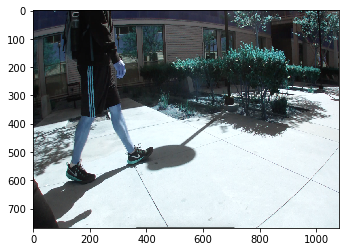

In [7]:
foot = cv2.imread('danny_foot.png')

resized_foot = cv2.resize(foot, (1080, 768))
plt.imshow(resized_foot)
plt.show()

In [14]:
labels = pd.read_csv('../images/labels.csv')
labels.head()

,Path,Label
0,/vans/vansvans250.jpg,1
1,/vans/vansvans244.jpg,1
2,/vans/vansvans278.jpg,1
3,/vans/vansvans293.jpg,1
4,/vans/vansvans287.jpg,1


In [8]:
try:
    positive_images_path = sys.argv[1]
    negative_images_path = sys.argv[2]
    model_name = sys.argv[3]
except:
    # defaults for my machine
    positive_images_path = "../images/positive/*.jpg"
    negative_images_path = "../images/negative/*.jpg"
    model_name = "orig_svm"

In [10]:
# this needs work
hog = init_hog()
model_path = '../models/'
model_file_name = model_name + '.pk1'